# Trust-Aware Mechanism

## One-Way Trading (with Directional Movement Predictions)

### Step 1: Load Prediction Results from ML Models

In [1]:
import pandas as pd

df = pd.read_excel('results of trend prediction.xlsx')

In [2]:
df.head()

,date,close,xgboost_preds,transformer_preds,vae_preds
0,2022-09-29,3.894,1,1,0
1,2022-09-30,3.868,1,1,0
2,2022-10-10,3.789,1,1,1
3,2022-10-11,3.786,1,1,1
4,2022-10-12,3.848,1,1,1


In [3]:
df['group'] = df.index // 10
df.head(12)

,date,close,xgboost_preds,transformer_preds,vae_preds,group
0,2022-09-29,3.894,1,1,0,0
1,2022-09-30,3.868,1,1,0,0
2,2022-10-10,3.789,1,1,1,0
3,2022-10-11,3.786,1,1,1,0
4,2022-10-12,3.848,1,1,1,0
5,2022-10-13,3.815,1,0,0,0
6,2022-10-14,3.903,1,1,1,0
7,2022-10-17,3.902,0,0,0,0
8,2022-10-18,3.895,1,0,1,0
9,2022-10-19,3.836,0,0,1,0


### Step 2: Online or Learning-Augmented Algorithms

In [4]:
import numpy as np
from scipy.special import lambertw

def get_optimal_threshold(L, U):
    theta = U / L
    alpha_star = 1 + lambertw((theta - 1) / np.e).real

    def threshold(w):
        return L + (alpha_star * L - L) * np.exp(alpha_star * w)

    return threshold

In [5]:
threshold_function = get_optimal_threshold(3, 5)
# print(threshold_function(0.5))

In [6]:
import pandas as pd
import numpy as np

def approximate_inverse_phi(phi_func, v, precision=0.001, max_iter=1000):
    w = 0.0
    for _ in range(max_iter):
        current_phi = phi_func(w)
        if abs(current_phi - v) < precision:
            return w
        if current_phi > v:
            return max(0.0, w - precision)
        w += precision
    return 1.0

def one_way_trading(df, phi_func):
    results = []
    grouped = df.groupby('group')

    for group_id, group in grouped:
        stock_left = 1.0
        converted = 0.0
        total_reward = 0.0

        for idx, row in group.iterrows():
            price = row['close']

            if price < phi_func(0):
                continue

            w_target = approximate_inverse_phi(phi_func, price)
            convert_amount = min(stock_left, w_target - converted)

            if convert_amount > 0:
                total_reward += convert_amount * price
                converted += convert_amount
                stock_left -= convert_amount

            if stock_left <= 0:
                break

        # force sell remaining stock at last day's close price
        if stock_left > 0:
            last_price = group.iloc[-1]['close']
            total_reward += stock_left * last_price
            converted += stock_left
            stock_left = 0.0

        results.append({
            'group': group_id,
            'converted_amount': converted,
            'reward': total_reward
        })

    return pd.DataFrame(results)

In [7]:
static_results = one_way_trading(df, threshold_function)
print(static_results)

    group  converted_amount    reward
0       0               1.0  3.855618
1       1               1.0  3.759707
2       2               1.0  3.863573
3       3               1.0  3.900839
4       4               1.0  3.993094
..    ...               ...       ...
56     56               1.0  3.967578
57     57               1.0  4.032709
58     58               1.0  4.044992
59     59               1.0  4.017219
60     60               1.0  4.000360

[61 rows x 3 columns]


In [8]:
def total_reward(results_df):
    return results_df['reward'].sum()

In [9]:
reward = total_reward(static_results)
print("Total reward:", reward)

Total reward: 230.81324100000003


In [10]:
def offline_optimal(df):
    results = []
    grouped = df.groupby('group')

    for group_id, group in grouped:
        max_price = group['close'].max()
        reward = 1.0 * max_price  # fully convert at the peak
        results.append({
            'group': group_id,
            'converted_amount': 1.0,
            'reward': reward
        })

    return pd.DataFrame(results)

In [11]:
offline_df = offline_optimal(df)
print(offline_df)

    group  converted_amount  reward
0       0               1.0   3.903
1       1               1.0   3.824
2       2               1.0   3.925
3       3               1.0   3.911
4       4               1.0   4.058
..    ...               ...     ...
56     56               1.0   4.014
57     57               1.0   4.075
58     58               1.0   4.067
59     59               1.0   4.109
60     60               1.0   4.027

[61 rows x 3 columns]


In [12]:
print("Offline optimal total reward:", total_reward(offline_df))

Offline optimal total reward: 234.90400000000002


In [13]:
import numpy as np
import pandas as pd
from copy import deepcopy

def approximate_inverse_phi(phi_func, v, precision=0.001, max_iter=1000):
    w = 0.0
    for _ in range(max_iter):
        current_phi = phi_func(w)
        if abs(current_phi - v) < precision:
            return w
        if current_phi > v:
            return max(0.0, w - precision)
        w += precision
    return 1.0

def empirical_ota(df, phi_init_func, delta=0.05, predictor='transformer_preds', L=3, U=5):
    results = []
    grouped = df.groupby('group')

    for group_id, group in grouped:
        stock_left = 1.0
        converted = 0.0
        total_reward = 0.0

        # initialize base threshold φ_0(w)
        phi = phi_init_func

        for i, row in group.iterrows():
            v = row['close']
            y_pred = row[predictor]
            true_up = group.iloc[i+1]['close'] > v if i + 1 < len(group) else None  # for feedback

            # backup φ' ← φ_{i-1}
            phi_backup = deepcopy(phi)

            # update threshold based on prediction
            if y_pred == 1:  # predicted UP
                phi = lambda w, phi=phi: min(phi(w) + delta, U)
            elif y_pred == 0:  # predicted DOWN
                phi = lambda w, phi=phi: max(phi(w) - delta, L)

            # perform decision
            if v >= phi(0):
                w_target = approximate_inverse_phi(phi, v)
                convert_amount = min(stock_left, w_target - converted)
                if convert_amount > 0:
                    total_reward += convert_amount * v
                    stock_left -= convert_amount
                    converted += convert_amount

            # check prediction accuracy: rollback if wrong
            if true_up is not None and ((true_up and y_pred == 0) or (not true_up and y_pred == 1)):
                phi = phi_backup

            if stock_left <= 0:
                break

        # forced convert remaining at last price
        if stock_left > 0:
            last_price = group.iloc[-1]['close']
            total_reward += stock_left * last_price
            converted += stock_left
            stock_left = 0.0

        results.append({
            'group': group_id,
            'converted_amount': converted,
            'reward': total_reward
        })

    return pd.DataFrame(results)

In [14]:
delta_transformer = 1

# Transformer-based OTA
ota_transformer = empirical_ota(df, threshold_function, delta=delta_transformer, predictor='transformer_preds')
print("Transformer OTA Total Reward:", ota_transformer['reward'].sum())

Transformer OTA Total Reward: 231.292248


In [15]:
def blindly_trust(df, predictor='transformer_preds'):
    results = []
    grouped = df.groupby('group')

    for group_id, group in grouped:
        stock_left = 1.0
        total_reward = 0.0
        sold = False

        for i, row in group.iterrows():
            price = row['close']
            pred = row[predictor]

            if pred == 0:
                total_reward += stock_left * price
                stock_left = 0.0
                sold = True
                break

        if not sold:
            last_price = group.iloc[-1]['close']
            total_reward += stock_left * last_price
            stock_left = 0.0

        results.append({
            'group': group_id,
            'converted_amount': 1.0,
            'reward': total_reward
        })

    return pd.DataFrame(results)

In [16]:
trust_results = blindly_trust(df, predictor='transformer_preds')
print(trust_results)
print("Total blindly-trust reward:", trust_results['reward'].sum())

    group  converted_amount  reward
0       0               1.0   3.815
1       1               1.0   3.824
2       2               1.0   3.707
3       3               1.0   3.879
4       4               1.0   3.956
..    ...               ...     ...
56     56               1.0   3.929
57     57               1.0   4.004
58     58               1.0   4.067
59     59               1.0   4.094
60     60               1.0   3.979

[61 rows x 3 columns]
Total blindly-trust reward: 230.52400000000003


### Step 3: Visualization 

In [17]:
import matplotlib.pyplot as plt

def plot_our_vs_blind(offline_df, ota_df, blind_df):
    groups = offline_df['group']
    
    cum_offline = offline_df['reward'].cumsum()
    cum_ota = ota_df['reward'].cumsum()
    cum_blind = blind_df['reward'].cumsum()

    ratio_ota = (cum_ota / cum_offline).fillna(0)
    ratio_blind = (cum_blind / cum_offline).fillna(0)

    plt.figure(figsize=(9, 5))
    plt.plot(groups, ratio_ota, label="Our Algorithm", linewidth=2, color='tab:blue')
    plt.plot(groups, ratio_blind, label="Blindly Trust", linewidth=2, color='tab:red')
    
    plt.xlabel("Group (Round)")
    plt.ylabel("Cumulative Online / Offline Reward")
    plt.title("Empirical Ratio: OTA vs Blindly Trust")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

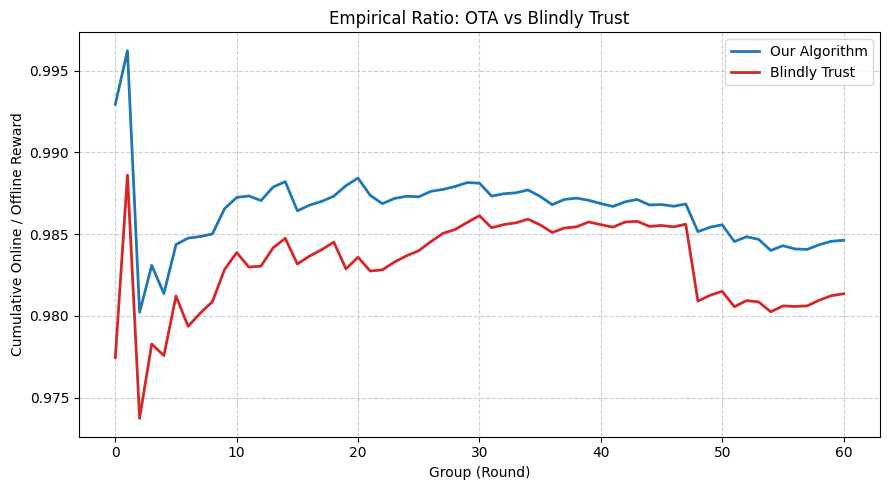

In [18]:
plot_our_vs_blind(offline_df, ota_transformer, trust_results)